In [77]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [78]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from sklearn.linear_model import LinearRegression

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#  Import and read the csv.
import pandas as pd
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("World-Happiness").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()
# Read in data from S3 Buckets
from pyspark import SparkFiles

url ="https://worldhappiness.s3.us-east-2.amazonaws.com/WHR_noNull.csv"
spark.sparkContext.addFile(url)
happiness_df = spark.read.csv(SparkFiles.get("WHR_noNull.csv"), sep=",", header=True, inferSchema=True).toPandas()
happiness_df

,country,year,world_region,happiness_score,economic_production,social_support,life_expectancy,freedom,generosity,perceptions_of_corruption
0,Denmark,2005,Western Europe,8.019,10.851,0.972,69.600,0.971,0.161533,0.237
1,Denmark,2008,Western Europe,7.971,10.880,0.954,70.080,0.970,0.272000,0.248
2,Finland,2020,Western Europe,7.889,10.750,0.962,72.100,0.962,-0.116000,0.164
3,Finland,2018,Western Europe,7.858,10.783,0.962,71.900,0.938,-0.127000,0.199
4,Finland,2021,Western Europe,7.842,10.775,0.954,72.000,0.949,-0.098000,0.186
...,...,...,...,...,...,...,...,...,...,...
2080,Central African Republic,2016,Sub-Saharan Africa,2.693,6.785,0.290,44.900,0.624,0.033000,0.859
2081,Syria,2013,Middle East and North Africa,2.688,8.396,0.585,58.760,0.455,0.225000,0.663
2082,Afghanistan,2017,South Asia,2.662,7.697,0.491,52.800,0.427,-0.121000,0.954
2083,Afghanistan,2021,South Asia,2.523,7.695,0.463,52.493,0.382,-0.102000,0.924


In [79]:
# Split our preprocessed data into our features and target arrays
y = happiness_df["happiness_score"] # y = dependent = ladder score
X = happiness_df[["economic_production", "social_support", "life_expectancy", "freedom", "generosity", "perceptions_of_corruption"]] # X = independent = any other variable



In [80]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [81]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [82]:
# Introduce regressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
# Print the intercept and coefficients
print("Intercept: ", regressor.intercept_)
print("Coefficients:")
list(zip(X, regressor.coef_))

Intercept:  -1.8088246302253044
Coefficients:


[('economic_production', 0.36258274988663175),
 ('social_support', 2.5211345812461268),
 ('life_expectancy', 0.02342681687673176),
 ('freedom', 1.0602070127123948),
 ('generosity', 0.7428672663190377),
 ('perceptions_of_corruption', -0.5915853002314541)]

In [84]:
# Create vector of predictions
y_pred = regressor.predict(X_test)

In [85]:
print(f"Prediction: {y_pred}")

Prediction: [6.29752464 5.17380454 6.23575028 5.32560136 4.94699568 5.444747
 5.46594487 5.61830467 5.38699116 7.19248872 5.14570453 5.53683234
 4.32489302 6.40751653 6.75879614 5.56114632 5.90782481 4.33702756
 5.33109267 6.19495998 4.29617989 4.14681436 4.66933927 5.78218882
 5.04356273 4.68670306 4.52092356 5.37381392 5.30277089 5.21809018
 6.81323049 5.30297796 5.51891858 5.03999913 4.14770201 5.69417246
 6.41466479 5.90973926 6.6777346  4.09850031 7.14330623 5.2252674
 6.05043291 7.11480789 4.51077646 6.12937375 6.80437026 4.66872458
 5.83189164 5.80401936 4.95165466 5.56224588 5.28065979 6.03414244
 6.88098509 5.71648453 5.87126046 5.38402559 6.35550275 7.08053506
 5.34577611 5.67446774 4.59880348 5.51105985 5.87262866 6.336381
 3.47717365 4.7026313  5.31526897 6.1713466  6.76804237 5.79045083
 5.92312935 6.22689785 4.14519946 6.33471416 5.14125053 5.12431271
 6.02066556 4.53481033 5.61906942 5.46038153 6.16366492 2.61220446
 5.27031521 7.11273464 5.63227863 3.88462607 6.15847199

In [86]:
# Show actual value with predicted value
regressor_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
values = regressor_diff.sort_values('Predicted value', ascending=False)
values.reset_index(drop=True, inplace=True)
values

,Actual value,Predicted value
0,6.378,7.467179
1,7.418,7.359683
2,7.603,7.305989
3,7.474,7.272726
4,7.060,7.265461
...,...,...
517,3.572,3.614910
518,2.997,3.605306
519,3.667,3.477174
520,3.639,3.425170


In [87]:
#Model Evaluation
from sklearn import metrics
MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('R squared: {:.2f}'.format(regressor.score(X, y)))
print('Mean Absolute Error:', MAE)
print('Mean Square Error:', MSE)
print('Root Mean Square Error:', RMSE)

R squared: 0.74
Mean Absolute Error: 0.44486828548708646
Mean Square Error: 0.32619845262881647
Root Mean Square Error: 0.5711378578143953


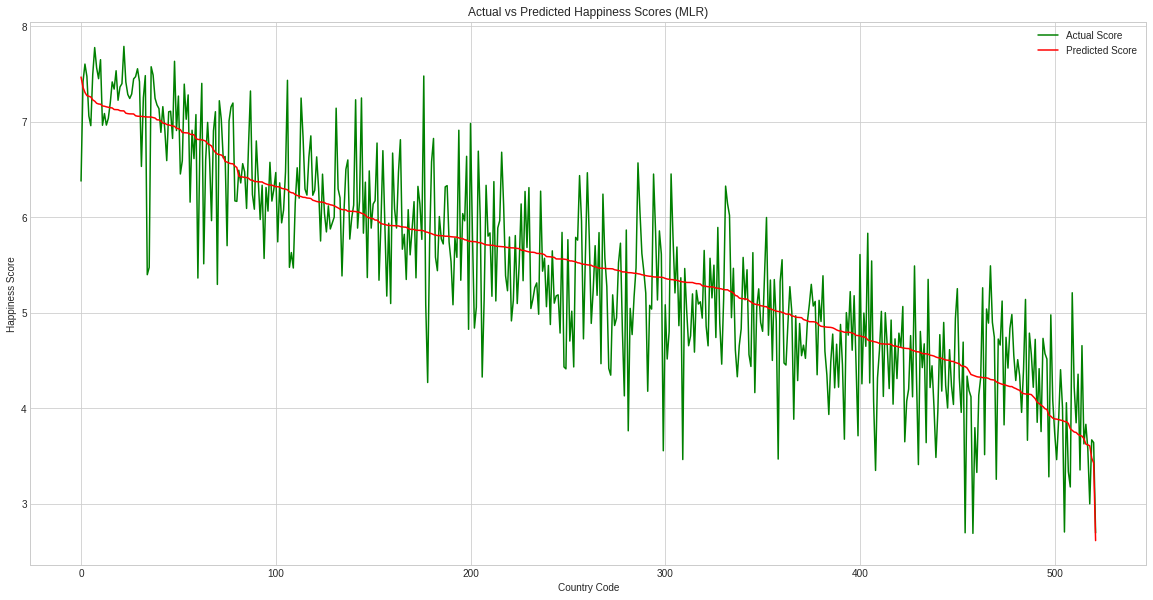

In [88]:
actual = values['Actual value']
predicted = values['Predicted value']
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(actual, color = 'green', label = 'Actual Score')
ax.plot(predicted, color = 'red', label = 'Predicted Score')
ax.set(xlabel='Country Code', ylabel='Happiness Score',
       title='Actual vs Predicted Happiness Scores (MLR)');
ax.legend(loc = 'upper right')
plt.show()

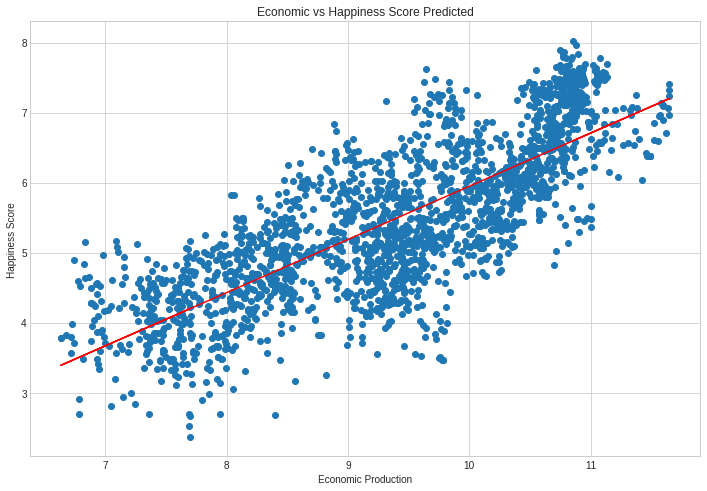

In [89]:
X = happiness_df.economic_production.values.reshape(-1, 1)
y = happiness_df.happiness_score
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
plt.figure(figsize=(12, 8))
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Economic Production')
plt.ylabel('Happiness Score')
plt.title('Economic vs Happiness Score Predicted')
plt.show()

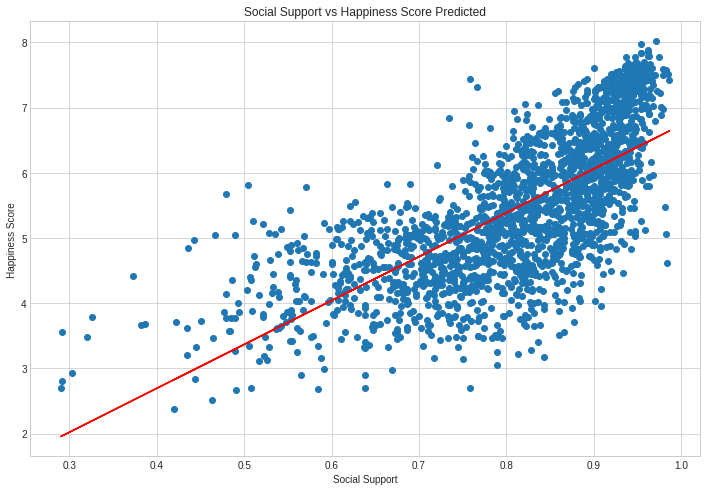

In [90]:
X = happiness_df.social_support.values.reshape(-1, 1)
y = happiness_df.happiness_score
model.fit(X, y)
y_pred = model.predict(X)
plt.figure(figsize=(12, 8))
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Social Support')
plt.ylabel('Happiness Score')
plt.title('Social Support vs Happiness Score Predicted')
plt.show()

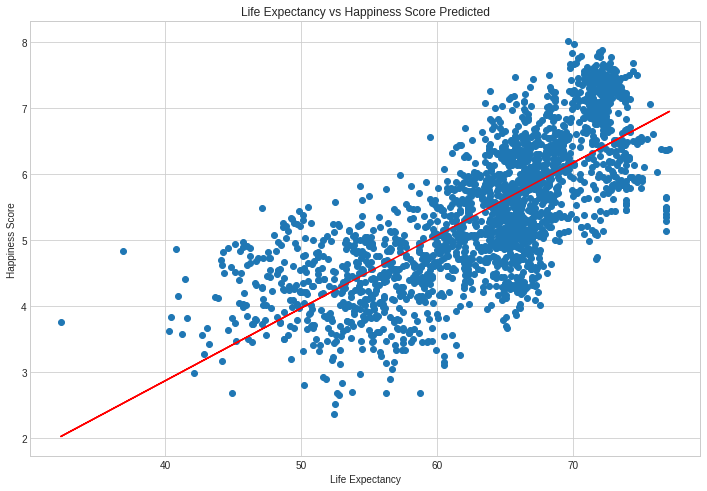

In [91]:
X = happiness_df.life_expectancy.values.reshape(-1, 1)
y = happiness_df.happiness_score
model.fit(X, y)
y_pred = model.predict(X)
plt.figure(figsize=(12, 8))
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Life Expectancy')
plt.ylabel('Happiness Score')
plt.title('Life Expectancy vs Happiness Score Predicted')
plt.show()

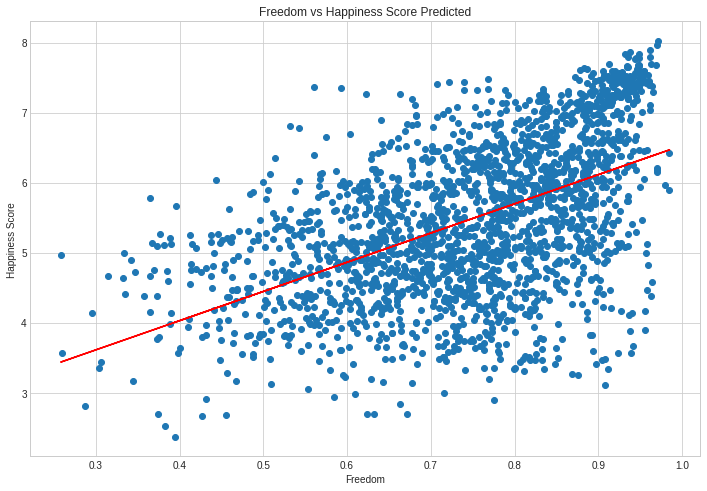

In [92]:
X = happiness_df.freedom.values.reshape(-1, 1)
y = happiness_df.happiness_score
model.fit(X, y)
y_pred = model.predict(X)
plt.figure(figsize=(12, 8))
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Freedom')
plt.ylabel('Happiness Score')
plt.title('Freedom vs Happiness Score Predicted')
plt.show()

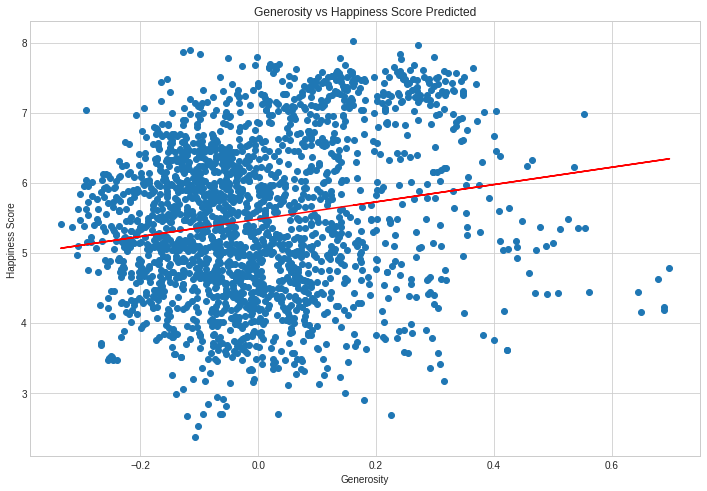

In [93]:
X = happiness_df.generosity.values.reshape(-1, 1)
y = happiness_df.happiness_score
model.fit(X, y)
y_pred = model.predict(X)
plt.figure(figsize=(12, 8))
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Generosity')
plt.ylabel('Happiness Score')
plt.title('Generosity vs Happiness Score Predicted')
plt.show()

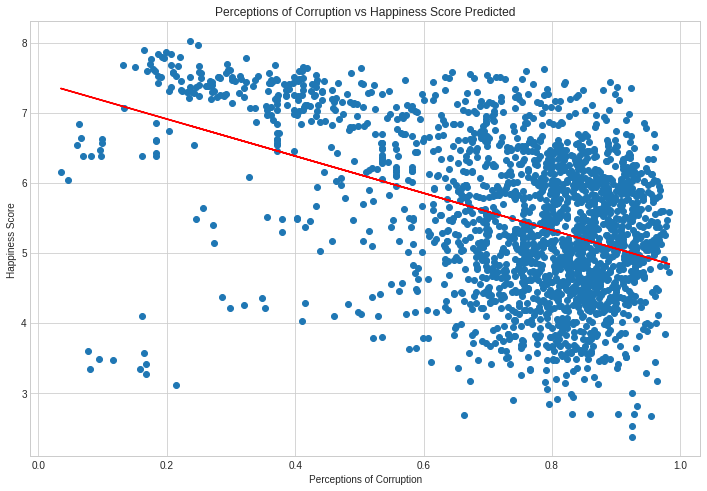

In [110]:
X = happiness_df.perceptions_of_corruption.values.reshape(-1, 1)
y = happiness_df.happiness_score
model.fit(X, y)
y_pred = model.predict(X)
plt.figure(figsize=(12, 8))
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Perceptions of Corruption')
plt.ylabel('Happiness Score')
plt.title('Perceptions of Corruption vs Happiness Score Predicted')
plt.show()

In [95]:
# RANDOM FOREST MODEL

import pandas as pd
#from path import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Read data and store into a Pandas DataFrame
happiness_no_null = pd.read_csv(url)
happiness_no_null.head()


,country,year,world_region,happiness_score,economic_production,social_support,life_expectancy,freedom,generosity,perceptions_of_corruption
0,Denmark,2005,Western Europe,8.019,10.851,0.972,69.60,0.971,0.161533,0.237
1,Denmark,2008,Western Europe,7.971,10.880,0.954,70.08,0.970,0.272000,0.248
2,Finland,2020,Western Europe,7.889,10.750,0.962,72.10,0.962,-0.116000,0.164
3,Finland,2018,Western Europe,7.858,10.783,0.962,71.90,0.938,-0.127000,0.199
4,Finland,2021,Western Europe,7.842,10.775,0.954,72.00,0.949,-0.098000,0.186


In [96]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df2 = happiness_no_null.copy()
df2['country'] = le.fit_transform(df2['country'])
df2.head()


,country,year,world_region,happiness_score,economic_production,social_support,life_expectancy,freedom,generosity,perceptions_of_corruption
0,38,2005,Western Europe,8.019,10.851,0.972,69.60,0.971,0.161533,0.237
1,38,2008,Western Europe,7.971,10.880,0.954,70.08,0.970,0.272000,0.248
2,46,2020,Western Europe,7.889,10.750,0.962,72.10,0.962,-0.116000,0.164
3,46,2018,Western Europe,7.858,10.783,0.962,71.90,0.938,-0.127000,0.199
4,46,2021,Western Europe,7.842,10.775,0.954,72.00,0.949,-0.098000,0.186


In [97]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
df3 = df2.copy()
df3['year'] = le.fit_transform(df2['year'])
df3.head()

,country,year,world_region,happiness_score,economic_production,social_support,life_expectancy,freedom,generosity,perceptions_of_corruption
0,38,0,Western Europe,8.019,10.851,0.972,69.60,0.971,0.161533,0.237
1,38,3,Western Europe,7.971,10.880,0.954,70.08,0.970,0.272000,0.248
2,46,15,Western Europe,7.889,10.750,0.962,72.10,0.962,-0.116000,0.164
3,46,13,Western Europe,7.858,10.783,0.962,71.90,0.938,-0.127000,0.199
4,46,16,Western Europe,7.842,10.775,0.954,72.00,0.949,-0.098000,0.186


In [98]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
df4 = df3.copy()
df4['world_region'] = le.fit_transform(df3['world_region'])
df4.head()

,country,year,world_region,happiness_score,economic_production,social_support,life_expectancy,freedom,generosity,perceptions_of_corruption
0,38,0,9,8.019,10.851,0.972,69.60,0.971,0.161533,0.237
1,38,3,9,7.971,10.880,0.954,70.08,0.970,0.272000,0.248
2,46,15,9,7.889,10.750,0.962,72.10,0.962,-0.116000,0.164
3,46,13,9,7.858,10.783,0.962,71.90,0.938,-0.127000,0.199
4,46,16,9,7.842,10.775,0.954,72.00,0.949,-0.098000,0.186


In [99]:
# Define the features set.
X = df4.copy()
X = X.drop("happiness_score", axis=1)
X

,country,year,world_region,economic_production,social_support,life_expectancy,freedom,generosity,perceptions_of_corruption
0,38,0,9,10.851,0.972,69.600,0.971,0.161533,0.237
1,38,3,9,10.880,0.954,70.080,0.970,0.272000,0.248
2,46,15,9,10.750,0.962,72.100,0.962,-0.116000,0.164
3,46,13,9,10.783,0.962,71.900,0.938,-0.127000,0.199
4,46,16,9,10.775,0.954,72.000,0.949,-0.098000,0.186
...,...,...,...,...,...,...,...,...,...
2080,26,11,8,6.785,0.290,44.900,0.624,0.033000,0.859
2081,139,8,4,8.396,0.585,58.760,0.455,0.225000,0.663
2082,0,12,6,7.697,0.491,52.800,0.427,-0.121000,0.954
2083,0,16,6,7.695,0.463,52.493,0.382,-0.102000,0.924


In [100]:
# Define the target set.
y = df4["happiness_score"].ravel()
y[:5]

array([8.019, 7.971, 7.889, 7.858, 7.842])

In [101]:
# Create a random forest classifier.
rf_model = RandomForestRegressor(n_estimators=128, random_state=78)

In [102]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [103]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)

In [104]:
#Model Evaluation
import numpy as np

from sklearn import metrics
MAE = metrics.mean_absolute_error(y_test, predictions)
MSE = metrics.mean_squared_error(y_test, predictions)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print('R squared: {:.2f}'.format(rf_model.score(X_test_scaled, y_test)))
print('Mean Absolute Error:', MAE)
print('Mean Square Error:', MSE)
print('Root Mean Square Error:', RMSE)

R squared: 0.86
Mean Absolute Error: 0.3105829142720304
Mean Square Error: 0.1727535052483216
Root Mean Square Error: 0.4156362655595895


In [105]:
# Calculate feature importance in the Random Forest model.
importances = rf_model.feature_importances_
importances

array([0.56750233, 0.10218751, 0.19167075, 0.06046924, 0.0380143 ,
       0.04015586])

In [106]:
# We can sort the features by their importance.
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.5675023313820726, 'country'),
 (0.1916707490167692, 'world_region'),
 (0.10218751361508752, 'year'),
 (0.06046924197774704, 'economic_production'),
 (0.04015586388548477, 'life_expectancy'),
 (0.03801430012283896, 'social_support')]

In [107]:
# Create vector of predictions
y_pred2 = rf_model.predict(X_test)
y_pred2

array([6.68720313, 6.40153125, 6.60526562, 6.2676875 , 6.514875  ,
       6.64189062, 6.584     , 6.59379687, 6.43380469, 6.717875  ,
       6.535625  , 6.46755469, 6.32550781, 6.63649219, 6.67576562,
       6.45942187, 6.6140625 , 6.40153125, 6.44969531, 6.6888125 ,
       6.42704688, 6.321     , 6.23695312, 6.47878125, 6.30435156,
       6.2191875 , 6.23988281, 6.59796875, 6.39540625, 6.41696875,
       6.51392969, 6.38353906, 6.50919531, 6.33260156, 6.19959375,
       6.62858594, 6.57077344, 6.62809375, 6.60069531, 6.04473437,
       6.72507031, 6.46414844, 6.63721875, 6.69425781, 6.13003125,
       6.62886719, 6.53551562, 6.28973437, 6.5751875 , 6.56455469,
       6.36342969, 6.43696094, 6.43242187, 6.62933594, 6.71838281,
       6.44009375, 6.41703906, 6.40589844, 6.62115625, 6.72327344,
       6.5873125 , 6.44725781, 6.26796094, 6.4511875 , 6.59878125,
       6.61559375, 6.02942187, 6.23934375, 6.51475781, 6.62726562,
       6.68236719, 6.57799219, 6.712625  , 6.61077344, 6.27215

In [108]:
# Show actual value with predicted value
regressor_diff2 = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred2})
values2 = regressor_diff2.sort_values('Predicted value', ascending=False)
values2.reset_index(drop=True, inplace=True)
#regressor_diff2
values2

,Actual value,Predicted value
0,7.224,6.793945
1,7.575,6.789992
2,7.554,6.789992
3,7.533,6.786312
4,7.341,6.785930
...,...,...
517,4.720,6.044734
518,3.625,6.042492
519,3.572,6.038727
520,3.667,6.029422


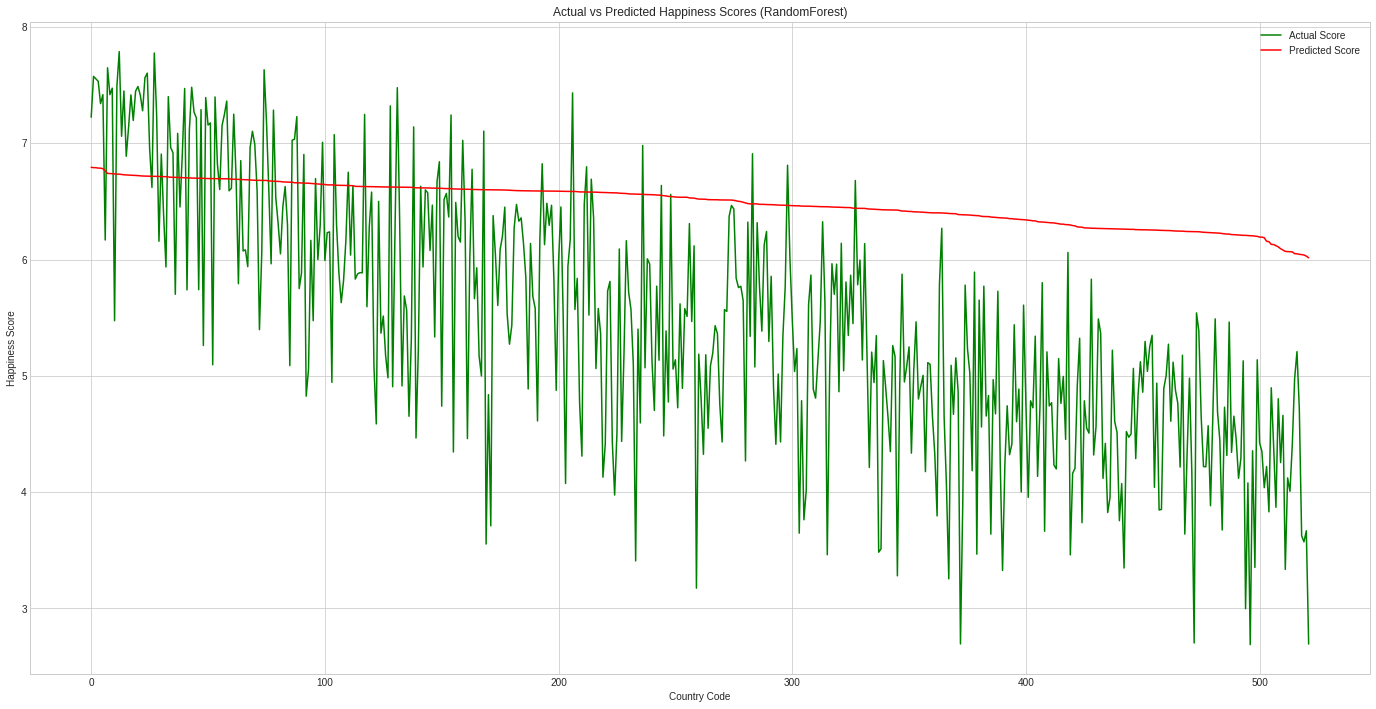

In [109]:
actual = values2['Actual value']
predicted = values2['Predicted value']
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(24, 12))

ax.plot(actual, color = 'green', label = 'Actual Score')
ax.plot(predicted, color = 'red', label = 'Predicted Score')
ax.set(xlabel='Country Code', ylabel='Happiness Score',
       title='Actual vs Predicted Happiness Scores (RandomForest)');
ax.legend(loc = 'upper right')
plt.show()